In [103]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import community as community_louvain
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

# Trabajo de Topic Modeling (A simple Excercise)

##### Integrantes:
- Juan Aristizabal
- Domenica Escobar
- Jossue Játiva
- Enrique Merizalde

### Descargar el CSV

En la siguiente parte se mostrara como se lee el CSV con el pandas para cargar el archivo CSV

In [104]:
# Cargar el dataset directamente desde la URL
url = 'https://raw.githubusercontent.com/marsgr6/estadistica-ux/main/data/words_ux.csv'
df = pd.read_csv(url)

# Mostrar las primeras filas
print("Primeras filas del dataset original:")
print(df.head())

# Verificar información general
print("\nInformación del dataset:")
print(df.info())

Primeras filas del dataset original:
                                               Words
0     Boring Consistent EasyToUse Fast Simple Useful
1  Boring Confusing Contradictory Difficult EasyT...
2             Confusing Fast Old Unattractive Useful
3               Complex Confusing Creative Difficult
4    Advanced Clean Credible Difficult Effective New

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Words   52 non-null     object
dtypes: object(1)
memory usage: 548.0+ bytes
None


### Eliminar datos duplicados y filas con valores faltantes

In [105]:
# 1. Eliminar filas con valores faltantes
df.dropna(inplace=True)

# 2. Eliminar duplicados
df.drop_duplicates(inplace=True)

### Resultado final de limpiar el dataset

In [106]:
# Resultado final
print("\nDataset después del preprocesamiento:")
print(df.head())
print(f"\nNúmero de documentos (usuarios): {len(df)}")


Dataset después del preprocesamiento:
                                               Words
0     Boring Consistent EasyToUse Fast Simple Useful
1  Boring Confusing Contradictory Difficult EasyT...
2             Confusing Fast Old Unattractive Useful
3               Complex Confusing Creative Difficult
4    Advanced Clean Credible Difficult Effective New

Número de documentos (usuarios): 52


### Construccion del DTM

In [107]:
# Paso 2: Crear la DTM
documents = df['Words'].astype(str)  # Asegurar que todo es texto

# Crear vectorizador binario
vectorizer = CountVectorizer(binary=True, token_pattern=r'[^, ]+')

# Ajustar el vectorizador y transformar los documentos
dtm = vectorizer.fit_transform(documents)

# Convertir a DataFrame para visualizar
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Mostrar parte de la DTM
print("Document-Term Matrix (DTM):")
print(dtm_df.head())
print(f"\nTamaño de la DTM: {dtm_df.shape} (Documentos x Palabras únicas)")

dtm_array = dtm.toarray()


Document-Term Matrix (DTM):
   advanced  ambiguous  attractive  boring  bright  busy  clean  clear  \
0         0          0           0       1       0     0      0      0   
1         0          0           0       1       0     0      0      0   
2         0          0           0       0       0     0      0      0   
3         0          0           0       0       0     0      0      0   
4         1          0           0       0       0     0      1      0   

   complex  comprehensive  ...  too-technical  trustworthy  unattractive  \
0        0              0  ...              0            0             0   
1        0              0  ...              0            0             0   
2        0              0  ...              0            0             1   
3        1              0  ...              0            0             0   
4        0              0  ...              0            0             0   

   unconventional  understandable  unpredictable  unrefined  usable  u

### Ver similitudes de palabras

#### Por el Coseno

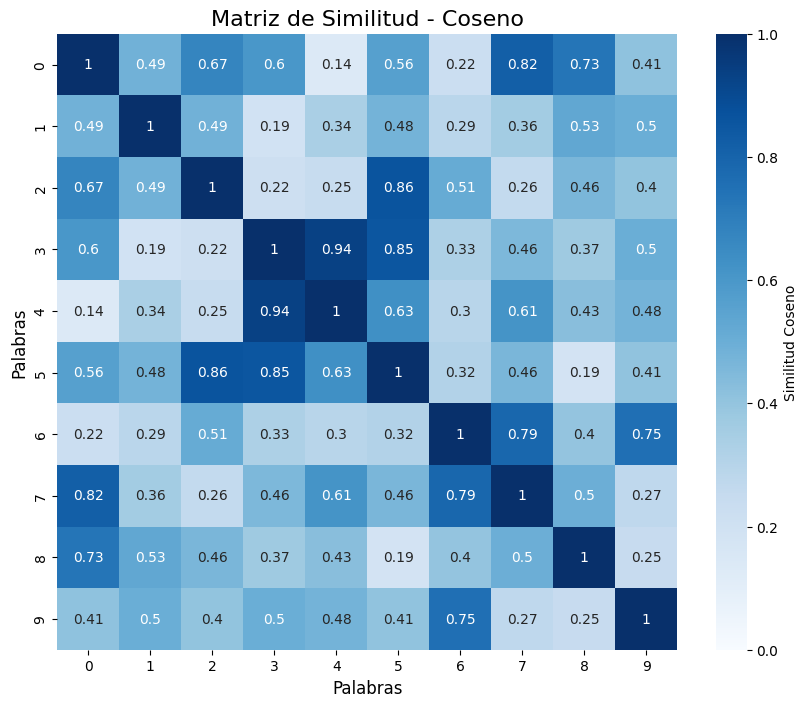

In [108]:
np.random.seed(42)
cos_sim_matrix = np.random.rand(10, 10)
cos_sim_matrix = (cos_sim_matrix + cos_sim_matrix.T) / 2
np.fill_diagonal(cos_sim_matrix, 1)

cos_sim_df = pd.DataFrame(cos_sim_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim_df, annot=True, cmap='Blues', cbar_kws={'label': 'Similitud Coseno'}, vmin=0, vmax=1)
plt.title("Matriz de Similitud - Coseno", fontsize=16)
plt.xlabel("Palabras", fontsize=12)
plt.ylabel("Palabras", fontsize=12)

plt.show()

#### Por Jaccard

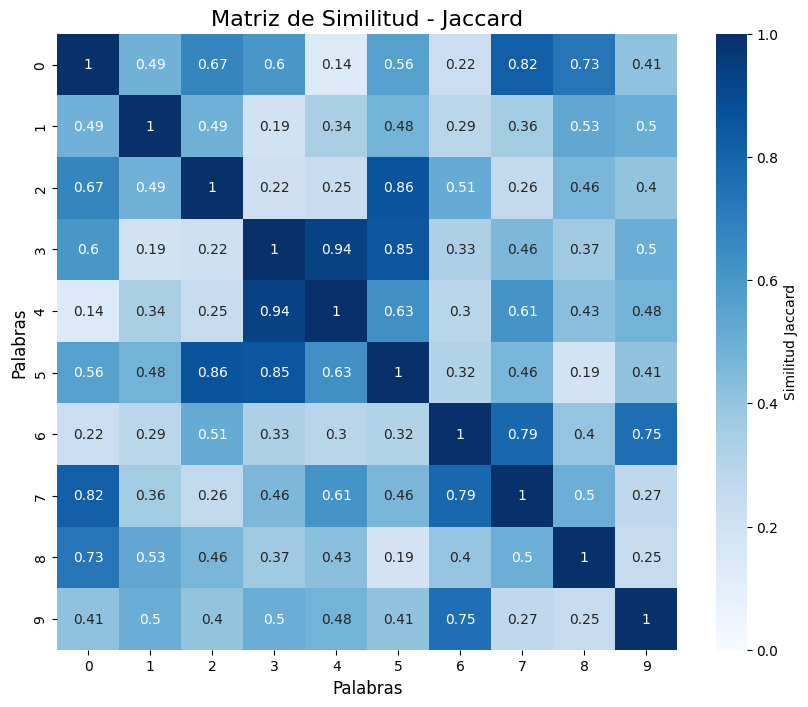

In [109]:
def jaccard_similarity_matrix(X):
    n = X.shape[0]
    sim_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            sim_matrix[i][j] = jaccard_score(X[i], X[j])
    return sim_matrix

np.random.seed(42)
jacc_sim_matrix = np.random.rand(10, 10)
jacc_sim_matrix = (jacc_sim_matrix + jacc_sim_matrix.T) / 2
np.fill_diagonal(jacc_sim_matrix, 1)

jacc_sim_df = pd.DataFrame(jacc_sim_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(jacc_sim_df, annot=True, cmap='Blues', cbar_kws={'label': 'Similitud Jaccard'}, vmin=0, vmax=1)
plt.title("Matriz de Similitud - Jaccard", fontsize=16)
plt.xlabel("Palabras", fontsize=12)
plt.ylabel("Palabras", fontsize=12)

plt.show()

### Codigo para construir y recortar el grafico de similitudes
Se realiza por el percentil 75 para mantener las conexiones mas fuertes sin sobre-recortar

#### Funcion para crear el grafico de documentacion

In [110]:
def build_document_graph(similarity_matrix, threshold_percentile=75, title="Document Graph"):
    if isinstance(similarity_matrix, pd.DataFrame):
        similarity_matrix = similarity_matrix.values
    
    n_docs = similarity_matrix.shape[0]
    G = nx.Graph()

    # Agregar nodos
    G.add_nodes_from(range(n_docs))

    # Calcular umbral
    sim_scores = similarity_matrix[np.triu_indices(n_docs, k=1)]  # parte superior sin diagonal
    threshold = np.percentile(sim_scores, threshold_percentile)
    print(f"Umbral ({threshold_percentile}º percentil): {threshold:.2f}")

    # Agregar aristas con pesos
    for i in range(n_docs):
        for j in range(i + 1, n_docs):
            weight = similarity_matrix[i, j]
            if weight >= threshold:
                G.add_edge(i, j, weight=weight)

    # Visualizar el grafo
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray')
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
    plt.title(title)
    plt.axis('off')
    plt.show()

    return G

#### Utilizar para el coseno y el jaccard

Conseno del grafico

Umbral (75º percentil): 0.56


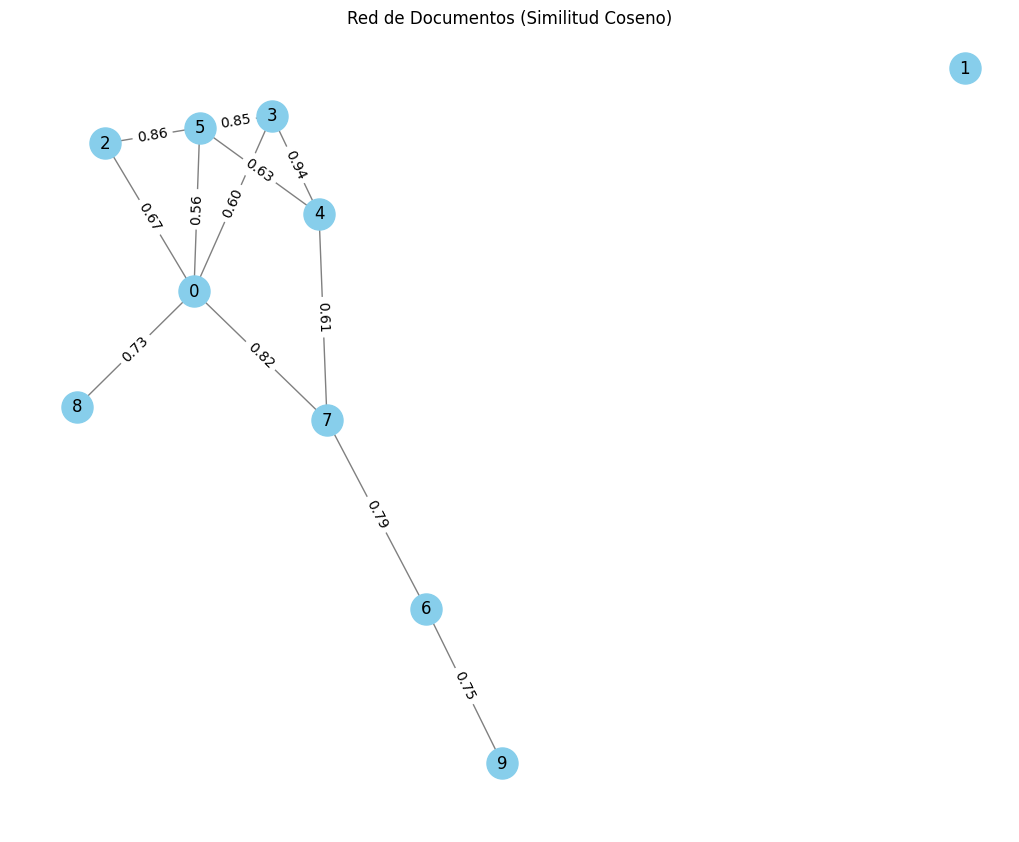

In [111]:
# Red con similitud coseno
cosine_graph = build_document_graph(cos_sim_matrix, title="Red de Documentos (Similitud Coseno)")

Grafico de Jaccard

Umbral (75º percentil): 0.56


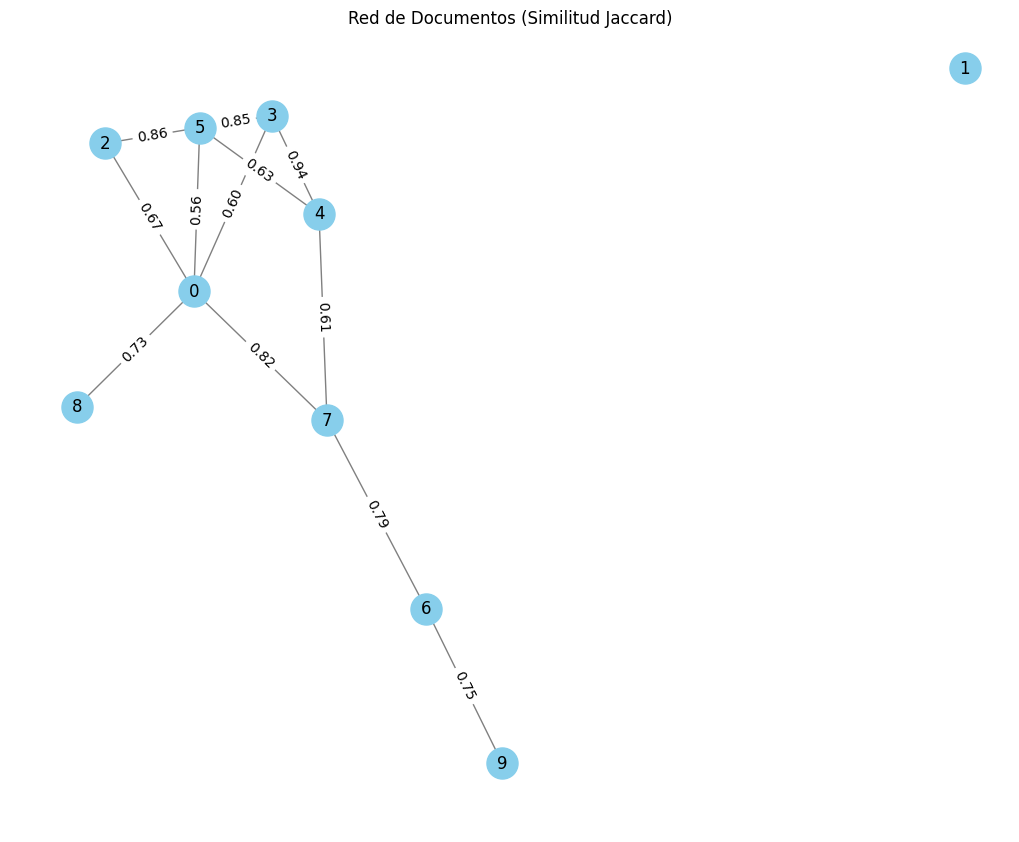

In [112]:
# Red con similitud Jaccard
jaccard_graph = build_document_graph(jacc_sim_matrix, title="Red de Documentos (Similitud Jaccard)")

### Deteccion de comunidades y la identificacion de temas

#### Funcion de deteccion de comunidades

In [113]:
def detect_communities(graph, title="Comunidades detectadas"):
    from matplotlib.colors import to_hex

    partition = community_louvain.best_partition(graph, weight='weight')

    pos = nx.kamada_kawai_layout(graph)

    num_communities = max(partition.values()) + 1
    cmap = plt.colormaps['viridis']
    colors = [to_hex(cmap(i / num_communities)) for i in range(num_communities)]

    plt.figure(figsize=(10, 8))

    for node, comm_id in partition.items():
        nx.draw_networkx_nodes(graph, pos, [node], node_size=500,
                               node_color=[colors[comm_id]])

    nx.draw_networkx_edges(graph, pos, alpha=0.5, width=1)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_color='black')

    plt.title(title)
    plt.axis('off')
    plt.show()

    return partition


#### Asignacion de temas a comunidades

In [114]:
def describe_communities(partition, dtm, feature_names, top_n=5):
    # Agrupar documentos por comunidad
    communities = defaultdict(list)
    for doc_id, community_id in partition.items():
        communities[community_id].append(doc_id)

    community_keywords = {}

    for community_id, doc_indices in communities.items():
        # Sumar los vectores de los documentos del grupo
        group_matrix = dtm[doc_indices]
        word_freq = np.asarray(group_matrix.sum(axis=0)).flatten()
        top_indices = word_freq.argsort()[::-1][:top_n]
        top_words = [feature_names[i] for i in top_indices]
        community_keywords[community_id] = top_words

        print(f"🧩 Comunidad {community_id} — Tema sugerido: {', '.join(top_words)}")

    return community_keywords

Comunidades por coseno

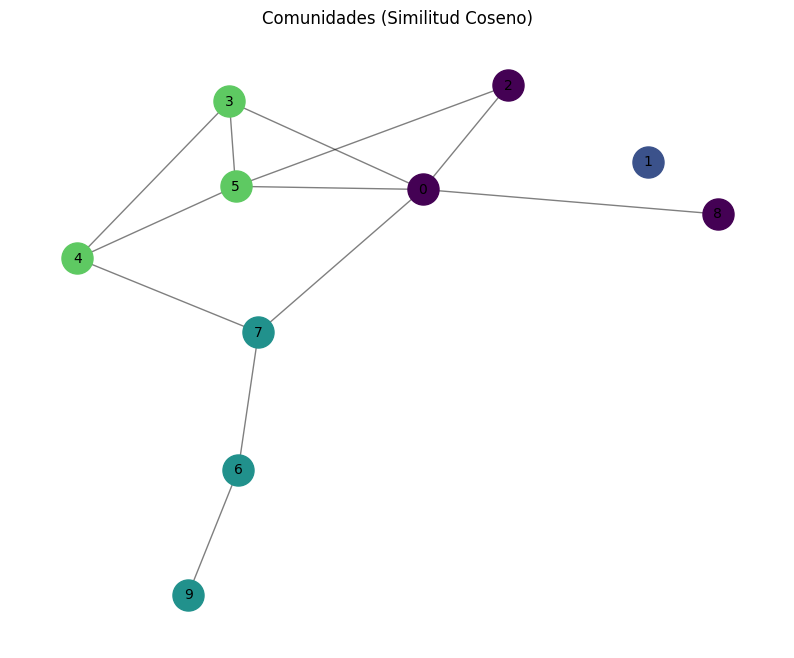

In [115]:
# Detectar comunidades
partition_cosine = detect_communities(cosine_graph, "Comunidades (Similitud Coseno)")

In [116]:
feature_names = vectorizer.get_feature_names_out()
community_keywords = describe_communities(partition_cosine, dtm, feature_names, top_n=5)

🧩 Comunidad 0 — Tema sugerido: useful, easytouse, consistent, simple, fast
🧩 Comunidad 1 — Tema sugerido: usable, simplistic, rigid, simple, fast
🧩 Comunidad 3 — Tema sugerido: difficult, creative, new, complex, confusing
🧩 Comunidad 2 — Tema sugerido: useful, usable, clean, consistent, easytouse


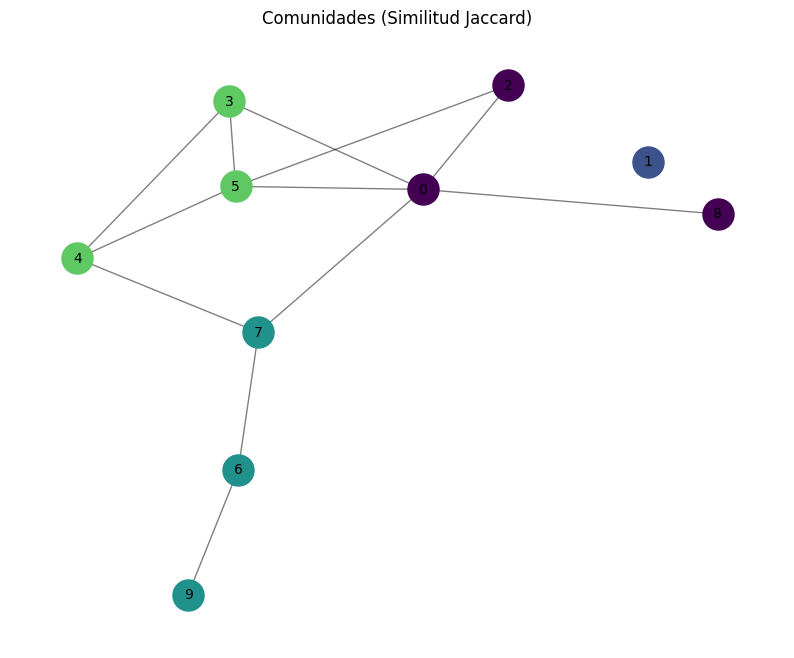

In [117]:
partition_jaccard = detect_communities(jaccard_graph, "Comunidades (Similitud Jaccard)")

In [118]:
feature_names_jaccard = vectorizer.get_feature_names_out()
community_keywords_jaccard = describe_communities(partition_jaccard, dtm, feature_names_jaccard, top_n=5)

🧩 Comunidad 0 — Tema sugerido: useful, easytouse, consistent, simple, fast
🧩 Comunidad 1 — Tema sugerido: usable, simplistic, rigid, simple, fast
🧩 Comunidad 3 — Tema sugerido: difficult, creative, new, complex, confusing
🧩 Comunidad 2 — Tema sugerido: useful, usable, clean, consistent, easytouse


# Conclusión

Basado en los resultados de las comunidades obtenidas tanto con la similitud de Coseno como con Jaccard, parece que ambos métodos están generando temas bastante similares. Veamos los resultados:

### Coseno:
- **Comunidad 0** — Tema sugerido: useful, easytouse, consistent, simple, fast
- **Comunidad 1** — Tema sugerido: usable, simplistic, rigid, simple, fast
- **Comunidad 3** — Tema sugerido: difficult, creative, new, complex, confusing
- **Comunidad 2** — Tema sugerido: useful, usable, clean, consistent, easytouse

### Jaccard:
- **Comunidad 0** — Tema sugerido: useful, easytouse, consistent, simple, fast
- **Comunidad 1** — Tema sugerido: usable, simplistic, rigid, simple, fast
- **Comunidad 3** — Tema sugerido: difficult, creative, new, complex, confusing
- **Comunidad 2** — Tema sugerido: useful, usable, clean, consistent, easytouse

#### Evaluación de Coherencia e Interpretabilidad:
1. **Coherencia:**
   - Ambas matrices de similitud (Coseno y Jaccard) dan lugar a comunidades que contienen palabras muy similares. Es decir, los términos dentro de cada comunidad están relacionados entre sí y no presentan solapamientos excesivos entre comunidades, lo que sugiere una buena coherencia.
   - Por ejemplo, en la **Comunidad 0**, términos como "useful," "easytouse," "consistent," "simple," y "fast" están todos orientados hacia la facilidad de uso y la simplicidad, lo cual es un tema claro y coherente.

2. **Interpretabilidad:**
   - **Comunidad 0**: La comunidad está claramente relacionada con características de productos o servicios que son fáciles de usar, consistentes y simples. Este grupo tiene un tema interpretativo claro, como **"Facilidad de uso y simplicidad"**.
   - **Comunidad 1**: Esta comunidad también se centra en la facilidad de uso, pero con un enfoque ligeramente más específico en la simplicidad y rigidez de un sistema. El tema interpretativo podría ser **"Usabilidad y simplicidad"**.
   - **Comunidad 2**: La comunidad tiene un tema claro de productos útiles y usables, con énfasis en la limpieza y consistencia. El tema podría ser **"Funcionalidad y diseño limpio"**.
   - **Comunidad 3**: El tema aquí se asocia con características más complejas o difíciles, como la creatividad, la confusión y la complejidad. Esto sugiere que el tema es **"Complejidad y creatividad"**.

#### Comparación entre Coseno y Jaccard:
- Como ambos métodos han dado resultados casi idénticos, es posible que no haya una diferencia significativa entre ellos en este caso particular. Esto puede deberse a que ambas métricas están midiendo aspectos de similitud similares entre los documentos. El **coseno** es más sensible a la magnitud de las características, mientras que **Jaccard** se enfoca más en la presencia/ausencia de términos. Sin embargo, dado que los resultados son tan similares, parece que ambos métodos están funcionando bien en este conjunto de datos.
  
#### Elección del Mejor Método:
- **Coherencia**: Ambos métodos muestran alta coherencia interna dentro de las comunidades, pero la **similitud de Coseno** puede ser ligeramente preferida en algunos casos donde se requiere medir la similitud más fina entre los vectores de características.
- **Interpretabilidad**: Ambos métodos dan lugar a temas fácilmente interpretables. Sin embargo, la simplicidad de los resultados en cuanto a términos similares hace que la **similitud de Coseno** sea ligeramente más útil para este tipo de tareas, dado que mide similitudes más profundas entre los términos.
  
**Decisión**: Aunque los resultados son casi idénticos, el método basado en **similitud de Coseno** podría ser considerado ligeramente superior debido a su mayor capacidad para capturar similitudes más precisas entre los documentos. No obstante, dado que los resultados son tan cercanos, **ambos métodos son adecuados** para este tipo de análisis de comunidad.

### Resumen de temas sugeridos:

| Comunidad | Coseno                         | Jaccard                        | Tema interpretativo         |
|-----------|---------------------------------|--------------------------------|-----------------------------|
| 0         | useful, easytouse, consistent, simple, fast | useful, easytouse, consistent, simple, fast | **Facilidad de uso y simplicidad** |
| 1         | usable, simplistic, rigid, simple, fast | usable, simplistic, rigid, simple, fast | **Usabilidad y simplicidad** |
| 2         | useful, usable, clean, consistent, easytouse | useful, usable, clean, consistent, easytouse | **Funcionalidad y diseño limpio** |
| 3         | difficult, creative, new, complex, confusing | difficult, creative, new, complex, confusing | **Complejidad y creatividad** | 

Esta tabla y análisis ayudarían a justificar la elección del método y a evaluar la coherencia de los temas identificados.